In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [32]:
pd.options.display.max_info_rows = 9999999

In [2]:
# считываем данны по регистрациям и авторизациям
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')

auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

In [13]:
# проверим какие данные к нам попадают
print(reg_data.head())
print(reg_data.info())

      reg_ts  uid
0  911382223    1
1  932683089    2
2  947802447    3
3  959523541    4
4  969103313    5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB
None


In [33]:
print(auth_data.head())
print(auth_data.info())

     auth_ts  uid
0  911382223    1
1  932683089    2
2  932921206    2
3  933393015    2
4  933875379    2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   auth_ts  9601013 non-null  int64
 1   uid      9601013 non-null  int64
dtypes: int64(2)
memory usage: 146.5 MB
None


In [35]:
# диапазон дат регистраций
pd.to_datetime(reg_data.reg_ts.agg(['min', 'max']), unit='s').dt.date

min    1998-11-18
max    2020-09-23
Name: reg_ts, dtype: object

In [47]:
# диапазон дат авторизаций
pd.to_datetime(auth_data.auth_ts.agg(['min', 'max']), unit='s').dt.date

min    1998-11-18
max    2020-09-23
Name: auth_ts, dtype: object

In [36]:
# итого: пропускв в данных нет, данные представлены больше чем за 20 лет, даты представлены в UNIX формате.
# думаю будет логично вынести диапазон возможных дат для расчёта функцией, для информирования пользователя

## Ячейка в которой задаются параметры ретеншена для расчёта. 

start_cohort - день первой когорты для расчёта.  
finish_cohort - день последней когорты для расчёта.  
interval - масштаб в котором нужно считать. Может принимать значения day, week, month, и year.  
num_intervals - количество едениц масштаба (дней/недель и т.д.) для вывода на графике.

In [46]:
# диапазон возможных дат для отображения retention:
pd.to_datetime(auth_data.auth_ts.agg(['min', 'max']), unit='s').dt.date

min    1998-11-18
max    2020-09-23
Name: auth_ts, dtype: object

In [39]:
start_cohort = '01.02.2019'
finish_cohort = '25.02.2019'
interval = 'day'
num_intervals = 30

In [40]:
# функция для расчёта
def get_retention(reg_data, auth_data, start_cohort, finish_cohort, interval, num_intervals):
    """
    Функция расчета retention за указанный период
    Входные данные:
        reg_data - датафрейм с датой регистрации пользователей
        auth_data - датафрейм с целевыми действиями пользователей
        start_cohort - день первой когорты для расчёта.
        finish_cohort - день последней когорты для расчёта.
        interval - масштаб в котором нужно считать. Может принимать значения day, week, month, и year.
        num_intervals - количество едениц масштаба (дней/недель и т.д.) для вывода на графике.
    
    Выходные данные:
        хитмап retention в процентах
    """
    # преобразуем даты из ts в вид типа %Y-%m-%d, с сохранением типа данных "дата"
    reg_data['reg_date'] = pd.to_datetime(pd.to_datetime(reg_data.reg_ts, unit="s").dt.date)
    auth_data['auth_date'] = pd.to_datetime(pd.to_datetime(auth_data.auth_ts, unit="s").dt.date)
    
    # условие для преобразования масштаба для вида читаемого функцией
    if interval == 'day':
        sis_int = 'D'
    elif interval == 'week':
        sis_int = 'W'
    elif interval == 'month':
        sis_int = 'M'  
    elif interval == 'year':
        sis_int = 'Y'  
    
    # явно преобразуем указанные даты первой и последней когорты в формат %Y-%m-%d
    start_cohort = pd.to_datetime(datetime.strptime(start_cohort, "%d.%m.%Y").strftime("%Y-%m-%d"))
    finish_cohort = pd.to_datetime(datetime.strptime(finish_cohort, "%d.%m.%Y").strftime("%Y-%m-%d"))
    
    # фильтруем данные по тем датам регистрации которые были укзаны
    reg_data = reg_data.query("@start_cohort <= reg_date <= @finish_cohort")
    
    # джойним датафреймы с данными по авторизациям и регистрациям
    merge_df = auth_data.merge(reg_data, how='right', on='uid')
    
    # добовляем столбец с разницей между регистрацией и заходом (в еденицах масштаба)
    # и столбец с отметкой о регистрации (день или неделя или т.д)
    merge_df[f'{interval}_since_start'] = \
        np.floor((merge_df['auth_date'] - merge_df['reg_date']) / np.timedelta64(1, sis_int))
    merge_df[f'reg_{interval}'] = merge_df['reg_date'].dt.to_period(f'{sis_int}').dt.start_time
    
    # убираем возможные повторные сессии в один день
    gr_df = merge_df \
        .groupby(['uid', 'auth_date', 'reg_date', f'{interval}_since_start', f'reg_{interval}'], as_index=False) \
        .agg({"auth_ts": 'count'}).drop(columns='auth_ts')
    
    # считаем количество пользователей заходивших в определённую отметку масштаба с даты регистрации
    piv = gr_df.groupby([f'reg_{interval}', f'{interval}_since_start'], as_index=False).agg({"uid": "count"})
    
    # убираем ненужные нули в числах
    piv[f'{interval}_since_start'] = piv[f'{interval}_since_start'].astype(int)
    
    # меняем тип, что бы потом на графике отображалось без времени
    piv[f'reg_{interval}'] = piv[f'reg_{interval}'].dt.date
    
    # сводной таблицей разбиваем по количеству прошедших отметок со дня регистрации
    piv = piv.pivot_table(index=f'reg_{interval}', columns=f'{interval}_since_start', values='uid')
    
    # отрезаем столбцы по заданному количеству num_intervals.
    piv.drop(piv.iloc[:, num_intervals + 1:], axis=1, inplace=True)
    
    # преобрауем абсолютные значения по пользователям в процентные от нулевой отметки
    proc_piv = piv.divide(piv.iloc[:, 0], axis=0) * 100
    
    # визуализация
    del proc_piv[0]  # убираем нулевую отметку для более чувствительной градации по цветам

    f, ax = plt.subplots(figsize=(25, 15))
    cmap = sns.color_palette("Blues")

    sns.heatmap(proc_piv, 
                annot=True, 
                linewidths=3, 
                ax=ax, 
                cmap=cmap, 
                square=False)

    ax.axes.set_title("Retention (percentages)", fontsize=30)
    ax.set_xlabel(f'{interval} since start', fontsize=15)
    ax.set_ylabel("Cohort", fontsize=15)
                   
    return (plt.show())

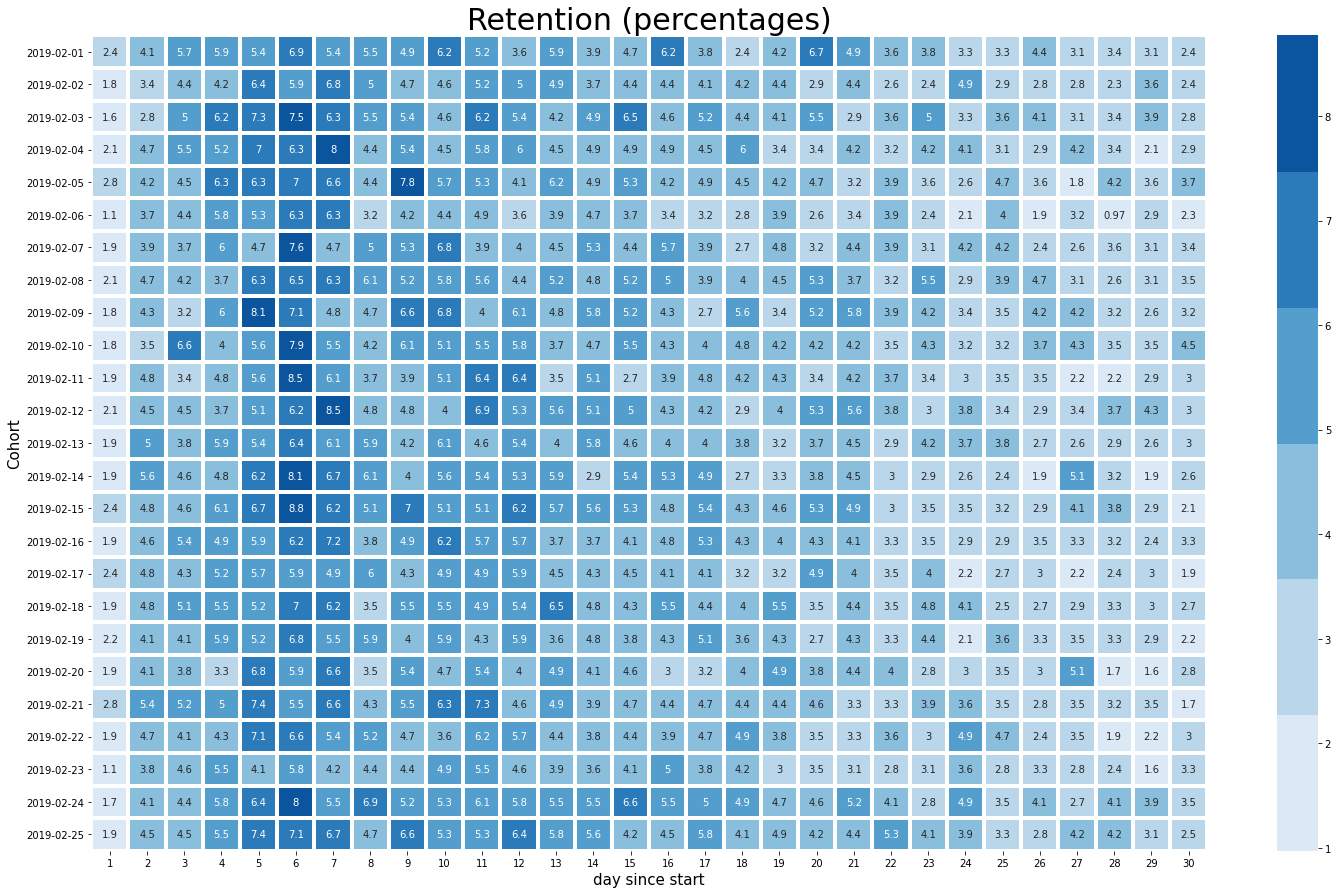

In [41]:
get_retention(reg_data, auth_data, start_cohort, finish_cohort, interval, num_intervals)

In [45]:
# функция для графика
def get_graph(reg_data, auth_data, start_cohort, finish_cohort, interval, num_intervals):
    """
    Функция построения графика среднего retention по когортам за указанный период
    Входные данные:
        reg_data - датафрейм с датой регистрации пользователей
        auth_data - датафрейм с целевыми действиями пользователей
        start_cohort - день первой когорты для расчёта.
        finish_cohort - день последней когорты для расчёта.
        interval - масштаб в котором нужно считать. Может принимать значения day, week, month, и year.
        num_intervals - количество едениц масштаба (дней/недель и т.д.) для вывода на графике.

    Выходные данные:
        график retention
    """
    # преобразуем даты из ts в вид типа %Y-%m-%d, с сохранением типа данных "дата"
    reg_data['reg_date'] = pd.to_datetime(pd.to_datetime(reg_data.reg_ts, unit="s").dt.date)
    auth_data['auth_date'] = pd.to_datetime(pd.to_datetime(auth_data.auth_ts, unit="s").dt.date)
    
    # условие для преобразования масштаба для вида читаемого функцией
    if interval == 'day':
        sis_int = 'D'
    elif interval == 'week':
        sis_int = 'W'
    elif interval == 'month':
        sis_int = 'M'  
    elif interval == 'year':
        sis_int = 'Y'  
    
    # явно преобразуем указанные даты первой и последней когорты в формат %Y-%m-%d
    start_cohort = pd.to_datetime(datetime.strptime(start_cohort, "%d.%m.%Y").strftime("%Y-%m-%d"))
    finish_cohort = pd.to_datetime(datetime.strptime(finish_cohort, "%d.%m.%Y").strftime("%Y-%m-%d"))
    
    # фильтруем данные по тем датам регистрации которые были укзаны
    reg_data = reg_data.query("@start_cohort <= reg_date <= @finish_cohort")
    
    # джойним датафреймы с данными по авторизациям и регистрациям
    merge_df = auth_data.merge(reg_data, how='right', on='uid')
    
    # добовляем столбец с разницей между регистрацией и заходом (в еденицах масштаба)
    # и столбец с отметкой о регистрации (день или неделя или т.д)
    merge_df[f'{interval}_since_start'] = \
        np.floor((merge_df['auth_date'] - merge_df['reg_date']) / np.timedelta64(1, sis_int))
    merge_df[f'reg_{interval}'] = merge_df['reg_date'].dt.to_period(f'{sis_int}').dt.start_time
    
    # убираем возможные повторные сессии в один день
    gr_df = merge_df \
        .groupby(['uid', 'auth_date', 'reg_date', f'{interval}_since_start', f'reg_{interval}'], as_index=False) \
        .agg({"auth_ts": 'count'}).drop(columns='auth_ts')
    
    # считаем количество пользователей заходивших в определённую отметку масштаба с даты регистрации
    piv = gr_df.groupby([f'reg_{interval}', f'{interval}_since_start'], as_index=False).agg({"uid": "count"})
    
    # убираем ненужные нули в числах
    piv[f'{interval}_since_start'] = piv[f'{interval}_since_start'].astype(int)
    
    # меняем тип, что бы потом на графике отображалось без времени
    piv[f'reg_{interval}'] = piv[f'reg_{interval}'].dt.date
    
    # сводной таблицей разбиваем по количеству прошедших отметок со дня регистрации
    piv = piv.pivot_table(index=f'reg_{interval}', columns=f'{interval}_since_start', values='uid')
    
    # отрезаем столбцы по заданному количеству num_intervals.
    piv.drop(piv.iloc[:, num_intervals + 1:], axis=1, inplace=True)
    
    # преобрауем абсолютные значения по пользователям в процентные от нулевой отметки
    proc_piv = piv.divide(piv.iloc[:, 0], axis=0) * 100
        
    del proc_piv[0]  # убираем нулевую отметку для более наглядного отображения изменений показателя
    
    # визуализация
    f, ax = plt.subplots(figsize=(25, 15))
    plt.grid(visible=True)
    
    sns.lineplot(data=proc_piv.mean())

    ax.axes.set_title("AVG Retention (percentages)", fontsize=30)
    plt.xticks(list(range(num_intervals + 1)))
    ax.set_xlabel(f'{interval} since start', fontsize=15)
    ax.set_ylabel("Percentages", fontsize=15)
                   
    return (plt.show())

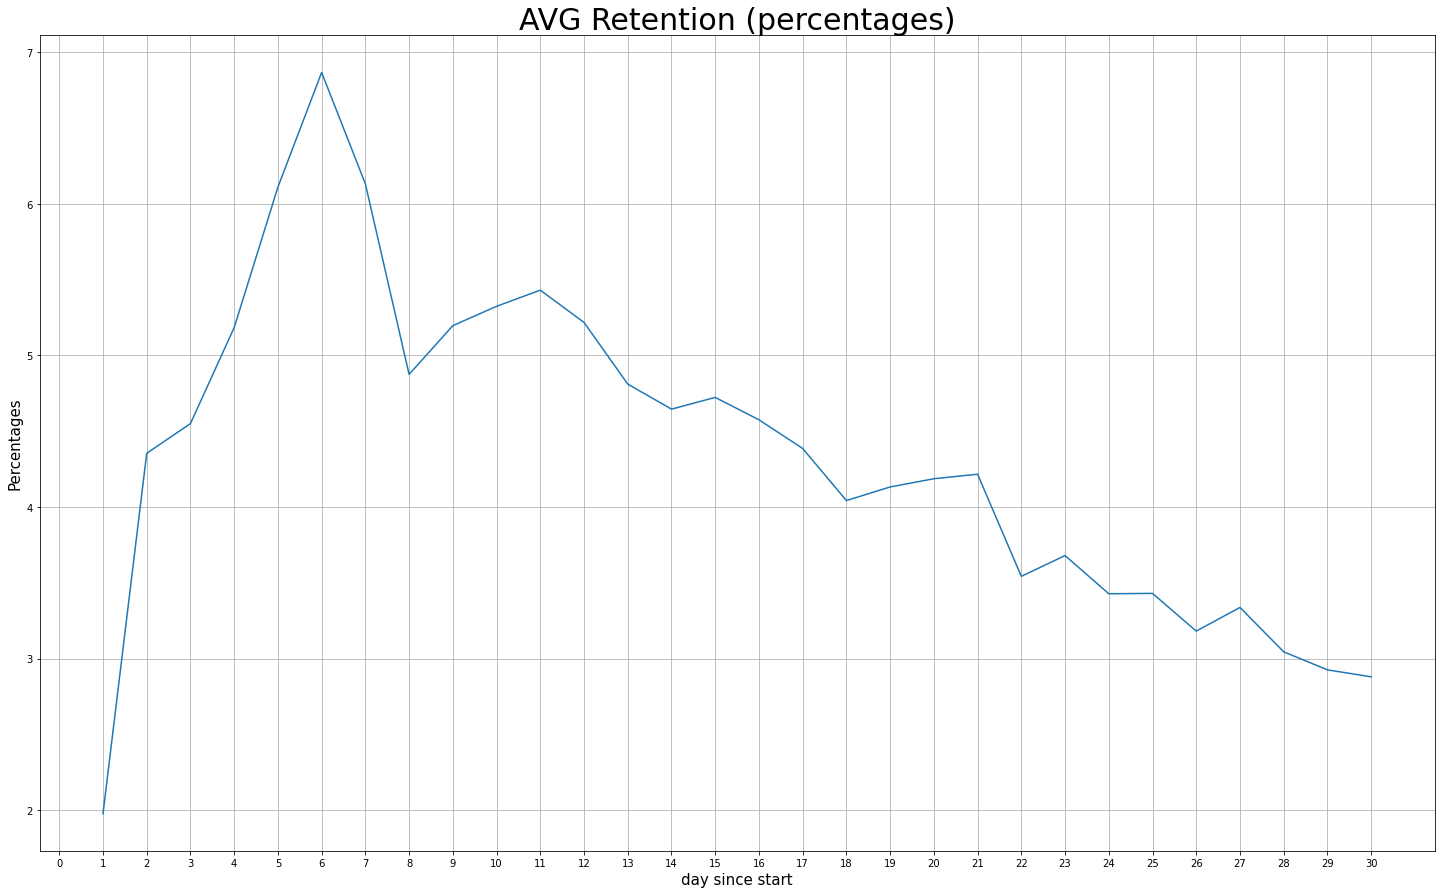

In [44]:
get_graph(reg_data, auth_data, start_cohort, finish_cohort, interval, num_intervals)